# Project II - Simulating a Rocket Launch

### M. Molter

This is the last excercise of the semester, hopefully, where I will tie in much of what I have learned to simulate the launch of a Saturn V rocket. 

This is the first project sufficiently complex to warrant using [`classes`](https://docs.python.org/3/tutorial/classes.html). These allow us to store reusable methods and data in a convenient package. Later you will see me modeling a `Stage` in a class. A stage has attributes like `thrust`, `fuel_mass`, and `empty_mass`. The `Stage` also can have operations performed on it, such as `burn(dt=10)`. A class allows the programmer to keep all this code together in a logical way.

## Exercise 1

Your mission is to build a computational model of a Saturn V rocket that indicates the effect of burning the fuel in all three rocket stages. Remember to include detailed comments in your simulation program. Relevant data for the sates of a Saturn V rocket is proved in Table 1. More detailed infromation on the Saturn V rocket can be foudn on the [Saturn V Wikipedia page](https://en.wikipedia.org/wiki/Saturn_V). Launch your rocket from rest in a direction that points radially outward from the center of the Earth (straight up), and maintain this oreintation throughout the rocket's motion. Provde a detailed assesment of the accuracy of your rocket model. By now, you should be able to demonstarte in detail how you would determine a sufficiently small value of $\Delta t$ to ensure an accurate solution. Produce graphs of the altitude, velocity, and acceleration of the rocket as a function of time from the instant the rocket was launched until the instant the third stage has been jettisoned. **NOTE:** build the model such that the time bettween prior stage jettisoning and current stage ignition is 3--4 seconds.

1. Build rocket model for three stages.
2. Determine suffient $\Delta t$
3. Plot t, x, v, and a from T=0 to the release of Stage III (i.e. no coasting)

|  Stage    | T (N) | $v_e$ (m/s) | empty mass (kg) | fully fueled mass (kg) |
|  :---:   | ----: | ----:       | ----:           | ----:                 |
| Stage I   | 34,000,000 | 2,580 | 131,000 | 2,300,000 |
| Stage II  |  5,000,000 | 4,130 |  36,000 |   480,000 |
| Stage III |  1,000,000 | 4,130 |  11,000 |   119,000 |
| Payload   |            |       |         |    52,000 |

### Solution 

As usual we start by importing our plotting libraries and numerical computation libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Now we can model acceleration. Because we are only working in a single dimension, we can simplifier our function to accept a list of forces and a mass.

In [2]:
def acceleration(m, *forces):
    ''' Return acceleration given a list of forces and mass. '''
    
    F_net = sum(forces)
    return F_net / m    

Again, the gravitational force equation is greatly simplified by working in a single spatial dimension.

In [3]:
def F_g(m, y, R=6.371e6, M=5.972e24, G=6.67408e-11):
    ''' Return gaviational force given mass and elevation '''
    
    return -(m * M * G) / (y + R)**2

Now, I have decided to encapsulate the logic and variables regarding a single stage into a class. This class will take care of things like the total mass of the rocket, the thurst, the fuel depletion rate, etc.

In [4]:
class Stage:
    ''' Class for handling stage calculations. '''
    
    def __init__(self, name=None, empty_mass=0, fuel_mass=0, thrust=0, exhaust_velocity=0):
        
        self.name = name
        
        self.thrust = thrust
        self.exhaust_velocity = exhaust_velocity
        
        self.fuel_mass = fuel_mass
        self.empty_mass = empty_mass
        
    def burn(self, dt):
        ''' Burn stage for dt seconds, return impulse. '''
        
        if not self.fuel_empty:
            self.fuel_mass -= (self.thrust / self.exhaust_velocity) * dt
    
    @property
    def fuel_empty(self):
        ''' Return true if out of fuel. '''
        
        return not self.fuel_mass > 0
            
    @property
    def mass(self):
        ''' Return combined fuel/empty mass. '''
        
        return self.fuel_mass + self.empty_mass

Now we construct a rocket class that handles the logic of a multi-stage launch. Stages are fed into the rocket as a list, and burned in order.

This code should obviously requires [refactoring](https://en.wikipedia.org/wiki/Code_refactoring). Notice that the Euler Method is written out three times throughout the class. Putting this in a method--that is flexible enough to handle the on/off nature of the stages--is on the todo list. Regardless, the code runs, and produces the correct solution--its just a small [technical debt](https://en.wikipedia.org/wiki/Technical_debt)

In [5]:
class Rocket:
    
    def __init__(self, stages, stage_delay=3.5):
        
        self.stages = stages
        self.stage_delay = stage_delay
    
    @property
    def mass(self):
        ''' Return sum of remaining mass from all stages. '''
        
        return sum(s.mass for s in self.stages)
    
    def add_stage(self, stage):
        self.stages.append(stage)
        
    def launch(self, dt, verbose=False):
        
        t = 0
        x = 0
        v = 0
        a = 0
        m = self.mass
        
        t_list = [t]
        x_list = [x]
        v_list = [v]
        a_list = [a]
        m_list = [m]
        
        for stage in self.stages:
            
            if verbose: print('Firing %s. t=%.0f, x=%.0f' % (stage.name, t, x))
            
            # Burn the stage until the stages fuel is depleted.
            while not stage.fuel_empty:
                a = acceleration(self.mass, stage.thrust, F_g(m=self.mass, y=x))
                
                t += dt
                x += v * dt
                v += a * dt
                
                stage.burn(dt)
                
                t_list.append(t)
                x_list.append(x)
                v_list.append(v)
                a_list.append(a)
                m_list.append(self.mass)
            
            if verbose: print('%s burn complete. t=%.0f, x=%.0f' % (stage.name, t, x))
            
            # If the stage is not the payload, coast for 3 seconds.
            if stage.name != 'Payload':
                pause = t + 3
                while t < pause:
                    a = acceleration(self.mass, F_g(m=self.mass, y=x))

                    t += dt
                    x += v * dt
                    v += a * dt

                    t_list.append(t)
                    x_list.append(x)
                    v_list.append(v)
                    a_list.append(a)
                    m_list.append(self.mass)   
                    
            # If the stage is the payload, coast until v==0
            elif stage.name == 'Payload':
                if verbose: print('Payload in free-fall.')
                
                while v > 0:
                    a = acceleration(self.mass, F_g(m=self.mass, y=x))

                    t += dt
                    x += v * dt
                    v += a * dt

                    t_list.append(t)
                    x_list.append(x)
                    v_list.append(v)
                    a_list.append(a)
                    m_list.append(self.mass)
                    
                if verbose: print('Payload stopped. x=%.0f' % x)
            
        return t_list, x_list, v_list, a_list, m_list

Now we stack the stages onto our rocket using the parameters we were given in the problem statement. Launch the rocket, and plot the trajectory.

Firing Stage I. t=0, x=0
Stage I burn complete. t=165, x=88544
Firing Stage II. t=168, x=94141
Stage II burn complete. t=535, x=693844
Firing Stage III. t=538, x=699960
Stage III burn complete. t=984, x=1190854
Firing Payload. t=987, x=1191868
Payload burn complete. t=987, x=1191868
Payload in free-fall.
Payload stopped. x=1199576


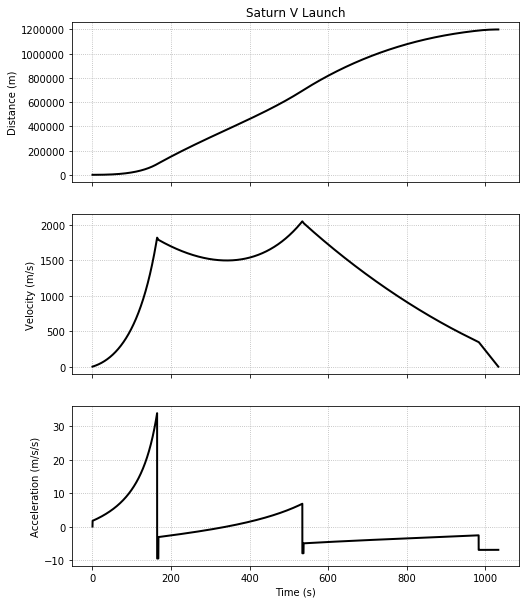

In [6]:
payload   = Stage(name='Payload', 
                  empty_mass=52e3
                 )

stage_I   = Stage(name='Stage I', 
                  empty_mass=131e3,
                  fuel_mass=2300e3-131e3,
                  thrust=34e6,
                  exhaust_velocity=2580
                 )

stage_II  = Stage(name='Stage II', 
                  empty_mass=36e3,
                  fuel_mass=480e3-36e3,
                  thrust=5e6,
                  exhaust_velocity=4130
                 )

stage_III = Stage(name='Stage III', 
                  empty_mass=11e3,
                  fuel_mass=119e3-11e3,
                  thrust=1e6,
                  exhaust_velocity=4130
                 )

# Fill stages in order of burn!
stages = [stage_I, stage_II, stage_III, payload]

rocket = Rocket(stages)

t, x, v, a, m = rocket.launch(dt=0.1, verbose=True)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)

fig.set_size_inches(8, 10)

ax1.plot(t, x, c='black', linewidth=2)
ax2.plot(t, v, c='black', linewidth=2)
ax3.plot(t, a, c='black', linewidth=2)

ax1.set_title('Saturn V Launch')

ax1.set_ylabel('Distance (m)')
ax2.set_ylabel('Velocity (m/s)')
ax3.set_ylabel('Acceleration (m/s/s)')

ax3.set_xlabel('Time (s)')

ax1.grid(which='both', linestyle=':')
ax2.grid(which='both', linestyle=':')
ax3.grid(which='both', linestyle=':')

plt.show()

We need to ensure that our $\Delta t$ is suffiently small. We will do this by plotting the final position for a number of timesteps, and finding when decreasing the timestep provides neglibile increases in accuracy.

In [7]:
for dt in [0.01, 0.1, 1.0, 10.0, 100.0]:
    payload   = Stage(name='Payload', 
                      empty_mass=52e3
                     )

    stage_I   = Stage(name='Stage I', 
                      empty_mass=131e3,
                      fuel_mass=2300e3-131e3,
                      thrust=34e6,
                      exhaust_velocity=2580
                     )

    stage_II  = Stage(name='Stage II', 
                      empty_mass=36e3,
                      fuel_mass=480e3-36e3,
                      thrust=5e6,
                      exhaust_velocity=4130
                     )

    stage_III = Stage(name='Stage III', 
                      empty_mass=11e3,
                      fuel_mass=119e3-11e3,
                      thrust=1e6,
                      exhaust_velocity=4130
                     )

    # Fill stages in order of burn!
    stages = [stage_I, stage_II, stage_III, payload]

    rocket = Rocket(stages)

    t, x, v, a, m = rocket.launch(dt=dt)
    
    print('For a dt of %s (s), max(x) = %.0f (km)' % (dt, max(x) / 1000.0))

For a dt of 0.01 (s), max(x) = 1201 (km)
For a dt of 0.1 (s), max(x) = 1200 (km)
For a dt of 1.0 (s), max(x) = 1232 (km)
For a dt of 10.0 (s), max(x) = 1841 (km)
For a dt of 100.0 (s), max(x) = 1376 (km)


It seems the difference between 0.1 seconds and 0.01 seconds is neglibile ($<0.1\%$). We will use 0.1 s as our dt.

## Exercise 2

The average distance from Earth to the Moon is 384,403 km. Use your model to determine what happens to the rocket after all the fuel in the three stages has been burned, and the stages have been jettisoned. Does you rocket make it to a distance of 384,403 km from Earth? Provide a detailed description of the behavior of your model.

### Solution

Clearly the three rocket stages do not provide sufficient thrust to make it to the Moon. I even hedged my bet by including the coasting phase of the payload (up until velocity falls back down to 0 m/s). 

For most of the flight of the rocket, it is deaccelerating. For half of Stage II and all of Stage III the rocket is slowing down. This is where a straight up model shows it inaccuracies. The goal of the real Saturn V stages is to put the rocket into orbit. This means that much of the energy of the stages is used to put the rocket into orbit (i.e. horizontal motion). This provides a benefit that is apparent when you compare the simulated plot to that of a real launch (see [Saturn V -- Wikipedia](https://en.wikipedia.org/wiki/Saturn_V))

![Trajectory for a the Apollo 17 mission -- Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Apollo17_Ascent_Trajectory.pdf/page1-800px-Apollo17_Ascent_Trajectory.pdf.jpg)

The difference is particularly noticble in the Stage II burn. While the Apollo 17 mission is accelerating horizontally, and converting much of its energy to kinetic energy (i.e. speed), our simulate rocket is accelerating vertically, converting all its burned energy to gravitational potential energy, and even contributing some of the kinetic energy from previous stages into additioanl gravitational potential energy.

## Exercise 3

IF you did not make it to the Moon (this is a hint for the result of Exercise 2), can you account for what's missing from the model, even though in the model you have used the correct Saturn V parameters provided by NASA? The answer to this question may require some significant investigation/thinking on your part. Again, provide a detailed answer/analysis to this question.

### Solution

Here is the trick. The Saturn V rocket does not simply point itself at the moon, and fire its stages one-by-one. The chemical energy in the stages is nowhere near sufficient for overcoming the deep gravitational well of the earth. Instead, the first few stages simply get the rocket into a specific orbit around the earth (i.e. refered to as the [parking orbit](https://en.wikipedia.org/wiki/Parking_orbit)). At the right moment, the remaining stages are fired (essentially horizontal to the surface of the Earth) launching the rocket into an large ellipical trajectory that intersects with the trajectory of the moon. In fact, for most of the trajectory (i.e. the several day trip) the rocket "coasts". This manuver is called a [trans-lunar injection](https://en.wikipedia.org/wiki/Trans-lunar_injection). What we had been attempting in our simulation is called a [direct injection](https://en.wikipedia.org/wiki/Parking_orbit).

## Exercise 4

**WARNING: DO NOT read the following until you have completed Exercise 3; otherwise, it may short-circuit your educational experience.**

Starting from the rocket's parking orbit (third stage not completely empty---hopefully you have discovered what the parking orbit is in researching your answer to Exercise 3), produce a detailed *pseudocode* for modeling the tran-lunar injection maneuver. Include the gravitational influence of the Moon in your pseudocode, (i.e. the Earth, the Moon, and the rocket are all interacting via the gravitational force). You are not expect to produce a working code for the trans--lunar injection, but you could try if you have time and sufficent interest. *HINT: IF you decide to try to produce the code for the trans lunar injection, keep it constrianed to a 2D problem*.

### Solution

Modeling the **trans-lunar injection** starting from the **parking orbit** is more of a *GA3 - Orbital Trajectories* model than what we have simulated above. The code from that activity already has what we need to model the launch---and is designed to handle multiple bodies (i.e. Earth, Moon, and Saturn V rocket).

We will make the following assumptions to limit the *scope* of this computational problem:

1. The Saturn V rocket is already in orbit around the Earth (i.e. travelling entirely tangentially to the Earth).
2. The Moon is orbit around the Earth (i.e. as modeled in *GA3*)
3. The injection is perfomed by a single burn leading to a velocity kick on the payload. 
4. We will ignore changes in mass due to this final burn, assuming it is intantanous, and the final mass is simply the payload mass.

I am going to do the *wrong* thing, and copy-and-paste the code from GA3 rather than importing it as a module (its finals week!). Its likely that once the code below compiles, the code above will have namespace collisions and need to be recompiled before it runs again.

First we need a calculation for computing distances in 2+ dimensions.

In [8]:
def dist(x):
    ''' Return the distance of point x from the origin <0, 0, .., 0>.
    
        Uses the linear algebra concept of a norm to calculate 
        Euclidean distance.
        
        Examples:
            Given two vectors A = <0,3,8> and B = <0,3,9>
                >>> A = np.asarray([0,3,8])
                >>> B = np.asarray([0,3,9])
        
            Find the length of A.
                >>> dist(A)

            Find the distance between A and B.
                >>> dist(A - B)
                
            Given a list of vectors C = [<1,1,1>, <2,3,5>, <8,3,7>].
                >>> C = np.asarray([[1,1,1], [2,3,5], [8,3,7]])
                
            Find the distances from the origin, O.
                >>> dist(C)
                
            Find the distances from point B.
                >>> dist(C - B)
            
        Args:
            x (np.array):   point or list of points.
            
        Returns:
            np.array: scalar distance or list of scalar distances.
    '''
    
    return np.linalg.norm(x, axis=(x.ndim - 1))

It would seem that the simplest approach is to again encapsulate the bodies into a class.

We additionally need a helper function to find the [unit vector](https://en.wikipedia.org/wiki/Unit_vector) between two orbital bodies.

In [9]:
def unit_vector(A, B):
    ''' Return unit vector form position A to position B. 
    
        Uses:
        
                        (A - B) / ||A - B||
        
        Args:
        
            A (np.array):    origin vector
            B (np.array):    destination vector
            
        Returns:
        
            np.array:        unit vector from origin to destination.
            
        Examples:
        
            Given two vectors A and B. 
                >>> A = np.asarray([0, 0])
                >>> B = np.asarray([1, 1])
            
            Find the unit vector from A to B.
                >>> unit_vector(A, B)
                array([0.70710678, 0.70710678])
    '''
      
    return (B - A) / dist(B - A)

Now we can write a class to store data and functions regarding an individual body.

A single body has attributes such as position, velocity, and mass; however, must know information about other bodies in the 'universe' to calculate its acceleration. Keeping track of other bodies in the universe is accomplished with  a [class attribute](https://www.python-course.eu/python3_class_and_instance_attributes.php). Class attributes *are not a beginner topic*, so feel free to brush over it if you need. Essentially a class is a pattern from which you create a class instance. That instance will have attributes about itself such as velocity or position. I have created a *class attribute*. This class attribute contains information about the collection of all instances of a class as a whole.

In [10]:
class Body:
    ''' A class to hold the represetation of and orbital body. '''
    
    # A class atribute to store all bodies in the universe.
    all_bodies = []
    
    def __init__(self, x0, v0, m):
        ''' Initialize an orbital body. '''
        
        self.t = 0.0
        self.x = x0
        self.v = v0
        self.m = m
        self.a = 0.0
        
        self.t_list = [self.t]
        self.x_list = [self.x]
        self.v_list = [self.v]
        self.a_list = [self.a]
        
        # Add body to universe.
        Body.all_bodies.append(self)
        
    def step(self, dt, modified=True):
        ''' Step the simulation forward one time-step, dt. '''
        
        self.a = self.acceleration()
        
        if modified:
            self.v = self.v + self.a * dt
            self.x = self.x + self.v * dt
        else:        
            self.x = self.x + self.v * dt
            self.v = self.v + self.a * dt
            
        self.t_list.append(self.t)
        self.x_list.append(self.x)
        self.v_list.append(self.v)
        self.a_list.append(self.a)  
        
    def acceleration(self, G=6.67408e-11):
        ''' Return acceleartion vector given x, v, and other bodies. 
        
            Args:
                bodies (list):  list of other interacting body objects.
                G (float):      gravitational constant (N*m*m/(kg *kg))
                
            Returns:
                ndarray:        acceleration vector
        '''
        
        F_net = np.zeros_like(self.x)
        for body in [b for b in Body.all_bodies if b != self]:
            # Determine Euclidian distance between two bodies.
            r = dist(self.x - body.x)
            
            # Determine the magnitude of the gravitational force.
            F = G * (self.m * body.m / np.power(r, 2)) * unit_vector(self.x, body.x)
            
            # Sum the forces
            F_net = F_net + F

        return F_net / self.m
    
    @classmethod
    def big_bang(cls):
        ''' Clear all the bodies from the universe. '''
        
        Body.all_bodies = []


Now let's try out our new class with a three-body gravitational problem. Here we are entering *analytically impossible* teritory!

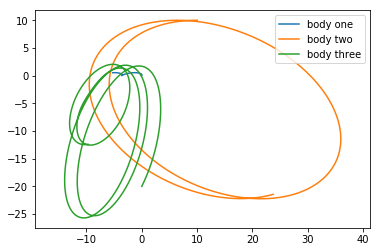

In [11]:
Body.big_bang()

ball_one = Body(x0 = np.asarray([0.0, 0.0]),
                v0 = np.asarray([0.0, 0.0]),
                 m = 6e11)

ball_two = Body(x0 = np.asarray([10.0, 10.0]),
                v0 = np.asarray([-2.0,  0.0]),
                 m = 1e10)

ball_thr = Body(x0 = np.asarray([0.0, -20.0]),
                v0 = np.asarray([0.5,   1.0]),
                 m = 1.0e1)

dt = 0.01
for i in range(15000):
    ball_one.step(dt)
    ball_two.step(dt)
    ball_thr.step(dt)
    
xs_one = np.vstack(ball_one.x_list)
xs_two = np.vstack(ball_two.x_list)
xs_thr = np.vstack(ball_thr.x_list)


plt.plot(xs_one[:,0], xs_one[:,1], label='body one')
plt.plot(xs_two[:,0], xs_two[:,1], label='body two')
plt.plot(xs_thr[:,0], xs_thr[:,1], label='body three')

plt.legend(loc=1)
plt.axis('equal')

plt.show()

We essentially have a very heavy, stationary object (blue) at (0, 0) getting passed slowly by a slightly lighter, but still massive object (orange). A third, fast moving, light object (green) is thrown at the system, and notice its behavior.

It initially orbits the blue body, then begins interacting with the orange body. Eventually, it gets ejected from the whole system! It appears to be some type of gravitational assist. Falling into the gravitational well of one body, gives the light object the acceleration it needs to reach the escape velocity of another body.

Now onto the **trans-lunar injection** problem. This is going to be a setup, with a lot of plug and checking.

I will start with the official injection parameters for the Apollo 8 mission ([Gravitational Escape Velocity with Saturn V Rocket](https://www.school-for-champions.com/science/gravitation_escape_velocity_saturn_v.htm#.WukqRIgvyUk))

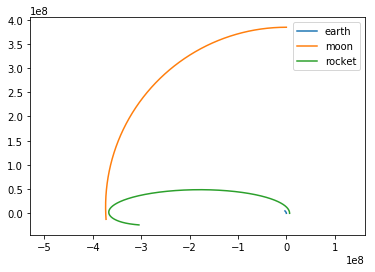

In [12]:
Body.big_bang()

r_earth = 6.371e6 # m
injection_alt = 334.436e3 # m
injection_vel =  10.423e3 # m/s

earth = Body(x0 = np.asarray([0.0, 0.0]),
             v0 = np.asarray([0.0, 0.0]),
               m = 5.9e24)

moon = Body(x0 = np.asarray([0, 384.4e6]),
            v0 = np.asarray([-1000.0, 0]),
             m = 7.3e22)

rocket = Body(x0 = np.asarray([injection_alt + r_earth, 0.0]),
              v0 = np.asarray([0.0, injection_vel + 317]),
               m = 25000)

dt = 7
for i in range(60*60*24):
    earth.step(dt)
    moon.step(dt)
    rocket.step(dt)
    
xs_earth =  np.vstack(earth.x_list)
xs_moon =   np.vstack(moon.x_list)
xs_rocket = np.vstack(rocket.x_list)


plt.plot(xs_earth[:,0], xs_earth[:,1], label='earth')
plt.plot(xs_moon[:,0], xs_moon[:,1], label='moon')
plt.plot(xs_rocket[:,0], xs_rocket[:,1], label='rocket')

plt.legend()
plt.axis('equal')

plt.show()

Well, that worked nicely. We just had to increase the injection velocity a bit (317 m/s) to make the orbit *more* eccentric. If the rocket launch was briefly delayed, the rocket would likely intersect with the moon.

My model is slightly oversimplified. It doesn't allow you to put the moon wherever you want in its orbit, but it gets the idea across.

It even provides a reasonable estimate of the travel time. While the real mission was four days, this takes just over six.

Notice that the mass of the moon seems to have very little effect on the trajectory of the rocket! 